In [108]:
# Read data
import pandas as pd
import numpy as np
df = pd.read_csv("./MLC_SP23/clean_data/regression_data.csv", low_memory=False, index_col=[0])
df.head()

,bbl,rs_share_diff,total_units_19,year_built,ejectment_count,possession_count,eviction_count,aleration_count,altered_lessthan5yrs,altered_morethan5yrs,...,pop_race_div_idx_19,boro_2,boro_3,boro_4,boro_5,hh_inc_avg_19_log1,pop_race_asian_pct_19_log1,pop_race_black_pct_19_log1,pop16_unemp_pct_19_log1,pop_mobile1_diff_state_pct_19_log1
0,1000780047,0.0000,483,2016,0.0,0.0,0.0,0.0,0.0,0.0,...,0.450691,0,0,0,0,12.276639,0.150551,0.018246,0.035008,0.074674
1,1001350019,0.0000,4,1915,0.0,0.0,0.0,0.0,0.0,0.0,...,0.457072,0,0,0,0,12.897523,0.096864,0.055298,0.002253,0.014341
2,1001620013,-0.0500,20,1915,0.0,0.0,0.0,0.0,0.0,0.0,...,0.612518,0,0,0,0,10.973689,0.461379,0.096629,0.037102,0.008935
3,1001630024,0.1875,16,1915,0.0,0.0,0.0,0.0,0.0,0.0,...,0.612518,0,0,0,0,10.973689,0.461379,0.096629,0.037102,0.008935
4,1001630033,0.0000,11,1915,0.0,0.0,0.0,1.0,0.0,1.0,...,0.612518,0,0,0,0,10.973689,0.461379,0.096629,0.037102,0.008935


In [8]:
df.columns

Index(['bbl', 'rs_share_diff', 'total_units_19', 'year_built',
       'ejectment_count', 'possession_count', 'eviction_count',
       'aleration_count', 'altered_lessthan5yrs', 'altered_morethan5yrs',
       'classanet_avg', 'enlargement_count', 'hpd_calls_2017',
       'hpd_calls_2018', 'hpd_calls_2019', 'dob_calls_2017', 'dob_calls_2018',
       'dob_calls_2019', 'b_violations_2017', 'b_violations_2018',
       'b_violations_2019', 'c_violations_2017', 'c_violations_2018',
       'c_violations_2019', 'cases_2017', 'cases_2018', 'cases_2019',
       'Heat and Hot Water_2017', 'Heat and Hot Water_2018',
       'Heat and Hot Water_2019', 'Tenant Action_2017', 'Tenant Action_2018',
       'Tenant Action_2019', 'CONH_2017', 'CONH_2018', 'CONH_2019',
       'Tenant Action/Harrassment_2017', 'Tenant Action/Harrassment_2018',
       'Tenant Action/Harrassment_2019', 'hh_inc_own_med_19',
       'own_cost_mort_med_19', 'own_burden_mort_med_19',
       'rent_contract_med_19', 'rent_burden_med_1

# Train-test split

In [75]:
X = df.drop(['rs_share_diff', 'bbl'], axis = 1)
y = df['rs_share_diff']

In [76]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [77]:
# Mean change in rs share
df['rs_share_diff'].mean()

-0.18852586470668642

In [78]:
# Mean change for large bldgs
df[df['total_units_19'] >= 7]['rs_share_diff'].mean()

-0.04442327408607823

In [79]:
# Mean change for small bldgs
df[df['total_units_19'] < 7]['rs_share_diff'].mean()

-0.737278916844144

# Random forest regressor

In [80]:
# Fit model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import time

scoring = {'r2':'r2',
           'mse':'neg_mean_squared_error',
           'rmse': 'neg_root_mean_squared_error'
}

param_grid = {'max_depth':[6, 8, 10],
              'n_estimators': [200, 300, 400]
}

start = time.time()

rf = RandomForestRegressor(random_state = 1)
gr = GridSearchCV(rf, param_grid = param_grid, scoring = scoring, refit = "rmse", cv = 4)
fit = gr.fit(X_train, y_train)

end = time.time()

print("Running grid search took", end - start, "seconds") # time in seconds to run grid search
print()
print(fit.best_params_)
print(fit.best_score_)

Running grid search took 1901.3489029407501 seconds

{'max_depth': 10, 'n_estimators': 400}
-0.3330758917888452


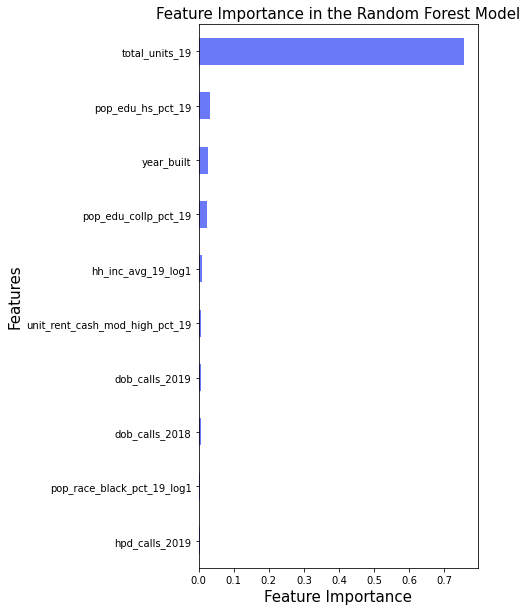

In [81]:
# get feature importance
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm

plt.figure(figsize=(5,10))
importances = pd.Series(fit.best_estimator_.feature_importances_, X_train.columns)
importances.sort_values().tail(10).plot.barh(color = '#6a79f7')
plt.title('Feature Importance in the Random Forest Model',fontsize=15)
plt.xlabel('Feature Importance',fontsize = 15)
plt.ylabel('Features',fontsize = 15)
plt.show()

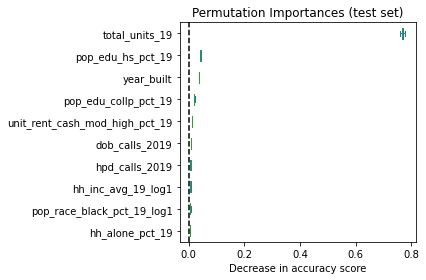

In [82]:
# permutation importance
from sklearn.inspection import permutation_importance

rf = fit.best_estimator_

result = permutation_importance(
    rf, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx][-10:].T,
    columns=X.columns[sorted_importances_idx][-10:],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

## Running RF with a six unit flag

In [109]:
df['six_unit_flag'] = np.where(df['total_units_19'] == 6, 1, 0)

In [110]:
df.groupby('six_unit_flag')['rs_share_diff'].mean()

six_unit_flag
0   -0.067174
1   -0.745503
Name: rs_share_diff, dtype: float64

In [117]:
df

,bbl,rs_share_diff,total_units_19,year_built,ejectment_count,possession_count,eviction_count,aleration_count,altered_lessthan5yrs,altered_morethan5yrs,...,boro_2,boro_3,boro_4,boro_5,hh_inc_avg_19_log1,pop_race_asian_pct_19_log1,pop_race_black_pct_19_log1,pop16_unemp_pct_19_log1,pop_mobile1_diff_state_pct_19_log1,six_unit_flag
0,1000780047,0.000000,483,2016,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,12.276639,0.150551,0.018246,0.035008,0.074674,0
1,1001350019,0.000000,4,1915,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,12.897523,0.096864,0.055298,0.002253,0.014341,0
2,1001620013,-0.050000,20,1915,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,10.973689,0.461379,0.096629,0.037102,0.008935,0
3,1001630024,0.187500,16,1915,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,10.973689,0.461379,0.096629,0.037102,0.008935,0
4,1001630033,0.000000,11,1915,0.0,0.0,0.0,1.0,0.0,1.0,...,0,0,0,0,10.973689,0.461379,0.096629,0.037102,0.008935,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38962,4001360036,1.000000,7,1924,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,11.333896,0.222322,0.007496,0.064376,0.007321,0
38963,4019390011,1.000000,68,2016,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,10.661933,0.101427,0.055693,0.150251,0.006320,0
38964,4049590008,0.857143,7,1930,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,10.921956,0.648695,0.000000,0.024720,0.000000,0
38965,4052630021,1.000000,47,1929,0.0,2.0,0.0,0.0,0.0,0.0,...,0,0,1,0,11.256711,0.373006,0.021625,0.033609,0.005244,0


In [111]:
X = df.drop(['rs_share_diff', 'bbl', 'six_unit_flag'], axis = 1)
y = df['rs_share_diff']

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [113]:
scoring = {'r2':'r2',
           'mse':'neg_mean_squared_error',
           'rmse': 'neg_root_mean_squared_error'
}

param_grid = {'max_depth':[4, 6, 8],
              'n_estimators': [200, 300, 400]
}

start = time.time()

rf = RandomForestRegressor(random_state = 1)
gr = GridSearchCV(rf, param_grid = param_grid, scoring = scoring, refit = "rmse", cv = 4)
fit = gr.fit(X_train, y_train)

end = time.time()

print("Running grid search took", end - start, "seconds") # time in seconds to run grid search
print()
print(fit.best_params_)
print(fit.best_score_)

Running grid search took 1432.4816892147064 seconds

{'max_depth': 8, 'n_estimators': 400}
-0.33385950872383385


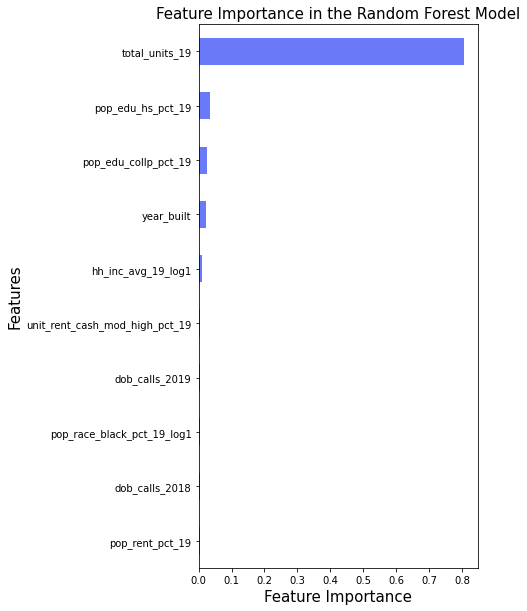

In [114]:
plt.figure(figsize=(5,10))
importances = pd.Series(fit.best_estimator_.feature_importances_, X_train.columns)
importances.sort_values().tail(10).plot.barh(color = '#6a79f7')
plt.title('Feature Importance in the Random Forest Model',fontsize=15)
plt.xlabel('Feature Importance',fontsize = 15)
plt.ylabel('Features',fontsize = 15)
plt.show()

In [116]:
importances

total_units_19                        0.806289
year_built                            0.021755
ejectment_count                       0.000053
possession_count                      0.000213
eviction_count                        0.000000
                                        ...   
pop_race_asian_pct_19_log1            0.002115
pop_race_black_pct_19_log1            0.004025
pop16_unemp_pct_19_log1               0.002571
pop_mobile1_diff_state_pct_19_log1    0.001800
six_unit_flag                         0.001384
Length: 76, dtype: float64

Essentially the same as without the flag.

## Running separate models for small and large buildings

### Small buildings

In [84]:
df_small_bldg = df[df['small_bldg_flag'] == 1]

In [85]:
X_small = df_small_bldg.drop(['rs_share_diff', 'bbl', 'six_unit_flag'], axis = 1)
y_small = df_small_bldg['rs_share_diff']

In [87]:
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X_small, y_small, test_size=0.25, random_state=1)

In [88]:
scoring = {'r2':'r2',
           'mse':'neg_mean_squared_error',
           'rmse':'neg_root_mean_squared_error'
}

param_grid = {'max_depth':[4, 6, 8],
              'n_estimators': [200, 300, 400]
}

start = time.time()

rf = RandomForestRegressor(random_state = 1)
gr_small = GridSearchCV(rf, param_grid = param_grid, scoring = scoring, refit = "rmse", cv = 4)
fit_small = gr.fit(X_train_small, y_train_small)

end = time.time()

print("Running grid search took", end - start, "seconds") # time in seconds to run grid search
print()
print(fit_small.best_params_)
print(fit_small.best_score_)

Running grid search took 353.42521715164185 seconds

{'max_depth': 10, 'n_estimators': 300}
-0.3474820873640089


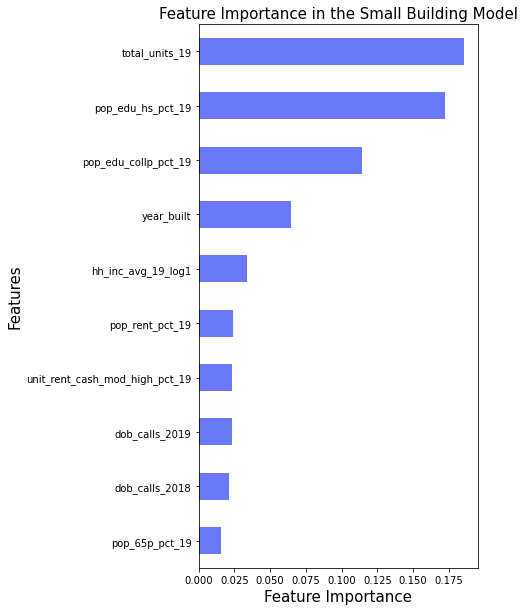

In [89]:
plt.figure(figsize=(5,10))
importances = pd.Series(fit_small.best_estimator_.feature_importances_, X_train_small.columns)
importances.sort_values().tail(10).plot.barh(color = '#6a79f7')
plt.title('Feature Importance in the Small Building Model',fontsize=15)
plt.xlabel('Feature Importance',fontsize = 15)
plt.ylabel('Features',fontsize = 15)
plt.show()

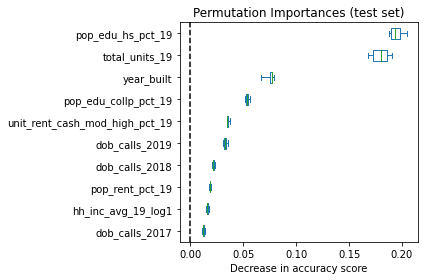

In [91]:
rf = fit_small.best_estimator_

result = permutation_importance(
    rf, X_train_small, y_train_small, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx][-10:].T,
    columns=X_train_small.columns[sorted_importances_idx][-10:],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

/Users/natehutchinson/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)
/Users/natehutchinson/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)
/Users/natehutchinson/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, c

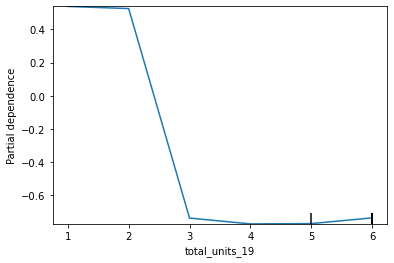

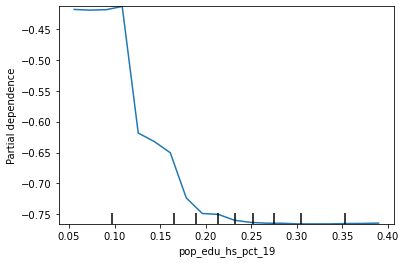

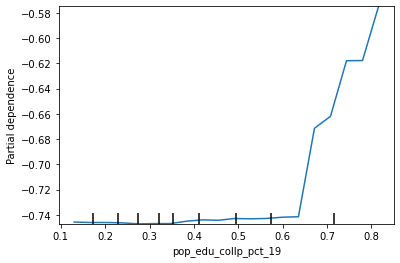

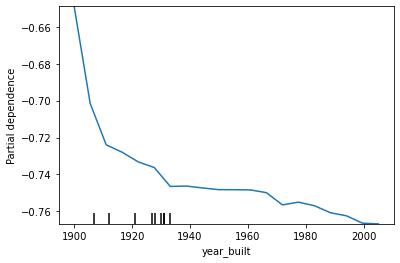

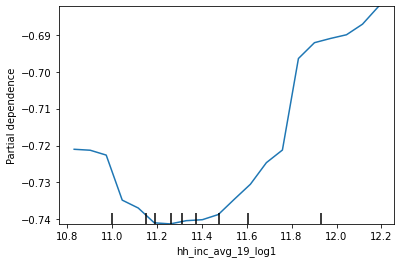

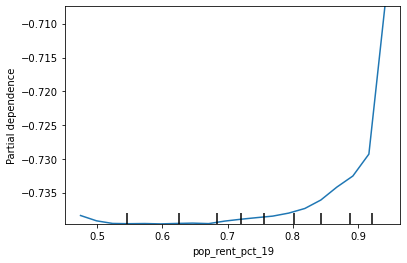

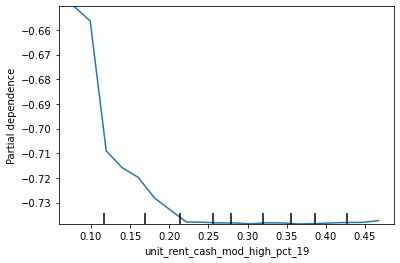

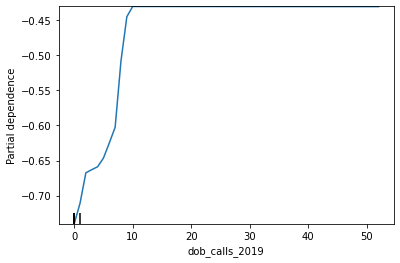

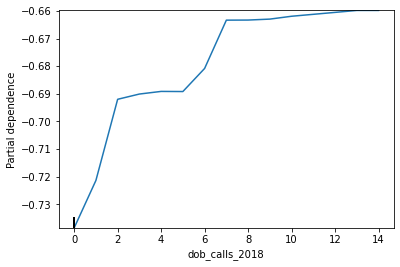

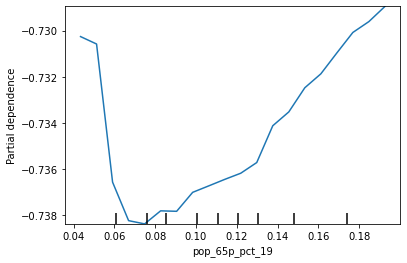

In [93]:
from sklearn.inspection import plot_partial_dependence

importances = pd.Series(fit_small.best_estimator_.feature_importances_, X_train_small.columns)
features = list(importances.sort_values(ascending = False)[:10].index)

for feature in features:
    plot_partial_dependence(fit_small, X_train_small, [feature], n_jobs=3, grid_resolution=20)
    fig = plt.gcf()

Small building model performs fairly well. RMSE is roughly half of the average change in rs_share.

### Large buildings

In [94]:
df_large_bldg = df[df['small_bldg_flag'] == 0]

In [95]:
X_large = df_large_bldg.drop(['rs_share_diff', 'bbl', 'six_unit_flag'], axis = 1)
y_large = df_large_bldg['rs_share_diff']

In [96]:
X_train_large, X_test_large, y_train_large, y_test_large = train_test_split(X_large, y_large, test_size=0.25, random_state=1)

In [99]:
scoring = {'r2':'r2',
           'mse':'neg_mean_squared_error',
           'rmse':'neg_root_mean_squared_error'
}

param_grid = {'max_depth':[4, 6, 8],
              'n_estimators': [100, 200, 300]
}

start = time.time()

rf = RandomForestRegressor(random_state = 1)
gr_large = GridSearchCV(rf, param_grid = param_grid, scoring = scoring, refit = "rmse", cv = 4)
fit_large = gr_large.fit(X_train_large, y_train_large)

end = time.time()

print("Running grid search took", end - start, "seconds") # time in seconds to run grid search
print()
print(fit_large.best_params_)
print(fit_large.best_score_)

Running grid search took 781.9970078468323 seconds

{'max_depth': 8, 'n_estimators': 300}
-0.3263381791682636


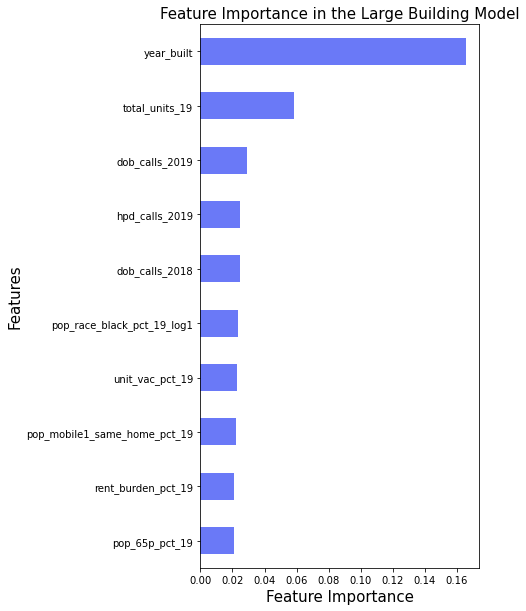

In [100]:
plt.figure(figsize=(5,10))
importances = pd.Series(fit_large.best_estimator_.feature_importances_, X_train_large.columns)
importances.sort_values().tail(10).plot.barh(color = '#6a79f7')
plt.title('Feature Importance in the Large Building Model',fontsize=15)
plt.xlabel('Feature Importance',fontsize = 15)
plt.ylabel('Features',fontsize = 15)
plt.show()

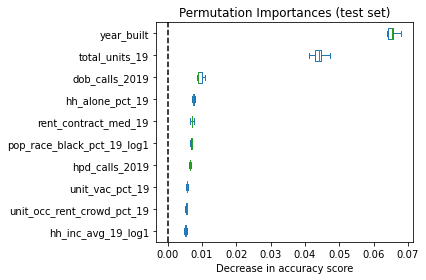

In [101]:
rf = fit_large.best_estimator_

result = permutation_importance(
    rf, X_train_large, y_train_large, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx][-10:].T,
    columns=X_train_large.columns[sorted_importances_idx][-10:],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

/Users/natehutchinson/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)
/Users/natehutchinson/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)
/Users/natehutchinson/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, c

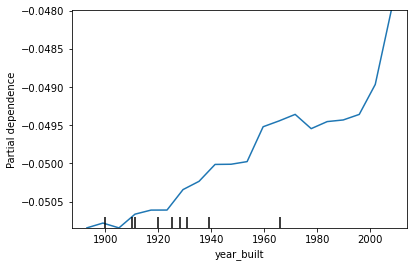

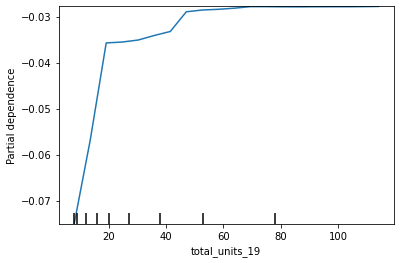

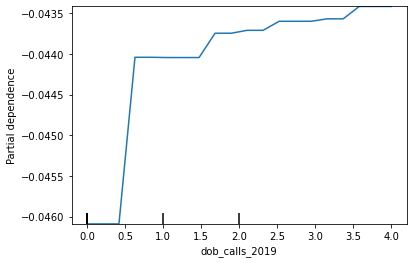

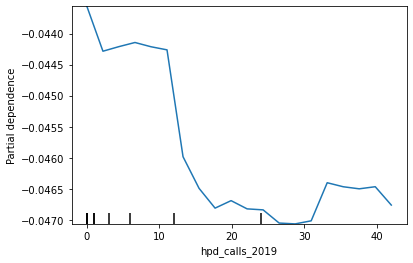

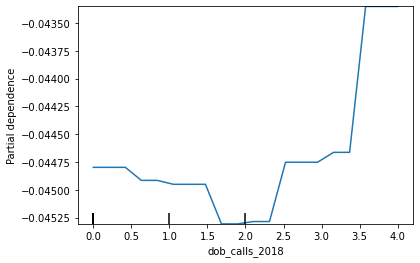

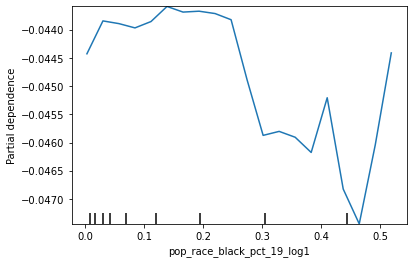

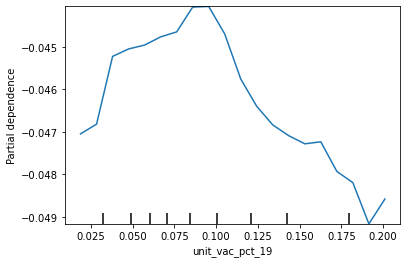

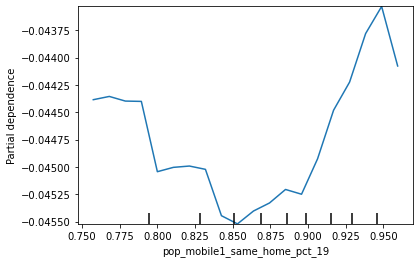

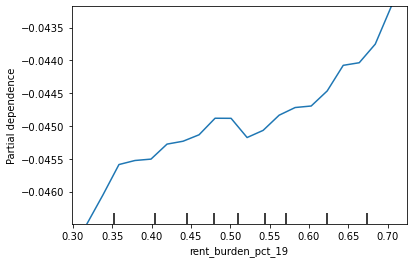

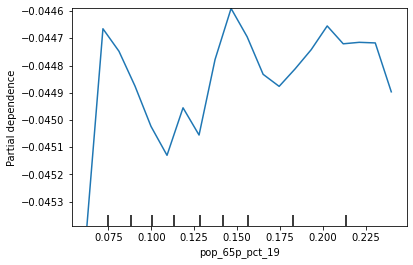

In [102]:
importances = pd.Series(fit_large.best_estimator_.feature_importances_, X_train_large.columns)
features = list(importances.sort_values(ascending = False)[:10].index)

for feature in features:
    plot_partial_dependence(fit_large, X_train_large, [feature], n_jobs=3, grid_resolution=20)
    fig = plt.gcf()

Large building RMSE is roughly the same as small building model despite having much smaller average value of rs_share.